In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from DSS_analyzer_Mariner import datareader, Data1D_GAUGE, Data1D_PumpingCurve, Data2D_XT_DSS

In [2]:
%load_ext autoreload
%autoreload 2

# Load field data for further comparison

In [3]:
stage = 7 # stage = 1 means there would be stage 1,2 plotted in the result. 

# controlling the amplitude of the gauge data.
coeff = 0.2

In [ ]:
dataiov3_path = "../../dataiov3/output/"

In [4]:
pumping_curve_datapath = dataiov3_path + f"prod/pumping_curve/pumping_curve_stage{stage}.npz"
frac_hit_location_path = "../../../../data/Fiber/CWC/POW-S CWC EventTable.xlsx"
lfdas_data_path = dataiov3_path + f"s_well/DASdata/LFDASdata_stg{stage}_swell.npz"

In [5]:
pumping_curve_datapath_next = f"../../dataiov3/output/prod/pumping_curve/pumping_curve_stage{stage+1}.npz"
lfdas_data_interval = f"../../dataiov3/output/s_well/DASdata/LFDASdata_stg{stage}_interval_swell.npz"
lfdas_data_path_next = f"../../dataiov3/output/s_well/DASdata/LFDASdata_stg{stage+1}_swell.npz"

In [6]:
# Load pumping curve data
pumping_curve_dataframe = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_datapath)
pumping_curve_dataframe_next = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_datapath_next)

In [7]:
DASdata = Data2D_XT_DSS.Data2D()
DASdata.loadnpz(lfdas_data_path)
DASdata_next = Data2D_XT_DSS.Data2D()
DASdata_next.loadnpz(lfdas_data_path_next)
DASdata_interval = Data2D_XT_DSS.Data2D()
DASdata_interval.loadnpz(lfdas_data_interval)

In [8]:
# Merge the DAS data
DASdata_new = Data2D_XT_DSS.merge_data2D([DASdata, DASdata_interval, DASdata_next])

In [9]:
cx = np.array([-1,1])
# fracture hit location detected by the monitoring well
frac_hit_stage_info, frac_hit_depth_info = datareader.event_marina_reader(frac_hit_location_path)
from DSS_analyzer_Mariner import event_analysis_tools
depth_group_info = event_analysis_tools.event_group_generator(frac_hit_stage_info, frac_hit_depth_info)
fracture_hit_depth_data1 = depth_group_info[stage-1]
fracture_hit_depth_data2 = depth_group_info[stage]

In [10]:
from DSS_analyzer_Mariner import Data3D_geometry
gauge_md_dataframe = Data3D_geometry.Data3D_geometry(f"../../dataiov3/output/s_well/geometry/gauge_md_swell.npz")
gauge_md = gauge_md_dataframe.data

In [11]:
ind = np.array(np.where(np.logical_and(gauge_md <=  np.max(fracture_hit_depth_data1) + 500, gauge_md >= np.min(fracture_hit_depth_data2) - 800))).flatten()

In [12]:
from tqdm import tqdm

In [13]:
DASdata_new.cal_timestamp_from_taxis()

In [14]:
start_time_lfdas = DASdata_new.timestamps[0]
end_time_lfdas = DASdata_new.timestamps[-1]
# Load and plot the pressure gauge data
gauge_dataframe_all = []
for iter in tqdm(ind): 
    datapath = f'../../dataiov3/output/s_well/gauge_data/gauge{iter+1}_data_swell.npz'
    gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(datapath)
    gauge_dataframe.crop(start_time_lfdas, end_time_lfdas)
    gauge_dataframe_all.append(gauge_dataframe)

100%|██████████| 6/6 [00:17<00:00,  2.98s/it]


In [15]:
depth_range = np.array([np.min(fracture_hit_depth_data2) - 800, np.max(fracture_hit_depth_data1) + 500])
DASdata_new.select_depth(depth_range[0], depth_range[1])

In [16]:
from datetime import timedelta

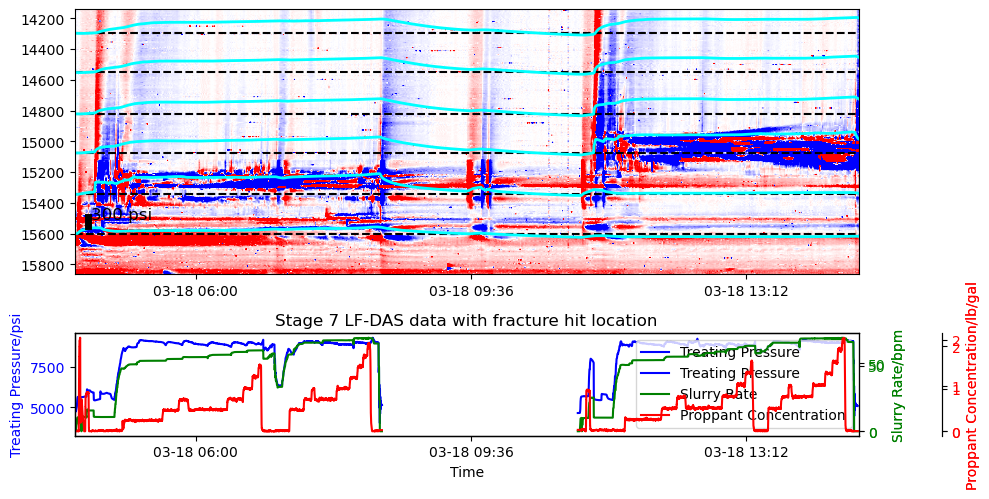

In [17]:
# scalar
tmp_taxis = np.repeat(gauge_dataframe_all[0].taxis[0] + timedelta(minutes=10), 2)
scalar_value = 300
tmp_value = np.array([+ gauge_md[ind][0] - 50, (scalar_value) * - coeff + gauge_md[ind][0] - 50])

plt.figure(figsize=(10, 5))

ax1 = plt.subplot2grid((6,4), (0,0), colspan=4, rowspan=4)
for i in range(len(gauge_md[ind])):
    ax1.axhline(y=gauge_md[ind][i], color='black', linestyle='--')
    ax1.plot(gauge_dataframe_all[i].taxis, (gauge_dataframe_all[i].data - gauge_dataframe_all[i].data[0]) * - coeff + gauge_md[ind][i], color='cyan', linewidth=2)
ax1.plot(tmp_taxis, tmp_value, color='black', linewidth=5)
ax1.text(tmp_taxis[0] + timedelta(minutes=3), tmp_value[0] - scalar_value/7, f"{scalar_value} psi", fontsize=12, color='black')
img1 = DASdata_new.plot_water_on_ax(ax1, use_timestamp=True)
img1.set_clim(cx * 5e2)

ax2 = plt.subplot2grid((6,4), (4,0), colspan=4, rowspan=2, sharex=ax1)
pumping_curve_dataframe.plot_all_vars(ax2)
pumping_curve_dataframe_next.plot_all_vars(ax2)

plt.title(f"Stage {stage} LF-DAS data with fracture hit location")
plt.tight_layout()
plt.show()

In [20]:
# Design the grid for the plot
# 1. gauge md, 2. fracture hit location

synthetic_gauge_md = depth_range[1] - gauge_md[ind]

In [21]:
# get the fracture hit location of two stages
frac_hit_depth_data1 = depth_group_info[stage-1]
frac_hit_depth_data2 = depth_group_info[stage]

In [24]:
avg_frac_hit_depth1 = np.mean(frac_hit_depth_data1)
avg_frac_hit_depth2 = np.mean(frac_hit_depth_data2)

synthetic_frac_hit_depth = np.array([depth_range[1] - avg_frac_hit_depth1, depth_range[1] - avg_frac_hit_depth2])

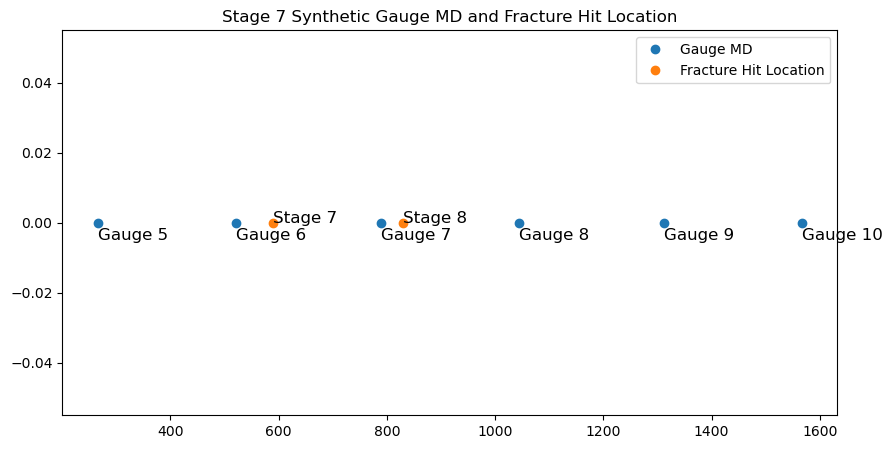

In [35]:
# Plot the synthetic gauge md and fracture hit location in a 1D plot
plt.figure(figsize=(10, 5))
plt.plot(synthetic_gauge_md, np.zeros_like(synthetic_gauge_md), 'o', label='Gauge MD')
# mark the pressure gauge number 
tmp_num = 0
for iter in ind:
    plt.text(synthetic_gauge_md[tmp_num], -0.005, f"Gauge {iter+1}", fontsize=12, color='black')
    tmp_num += 1
plt.plot(synthetic_frac_hit_depth, np.zeros_like(synthetic_frac_hit_depth), 'o', label='Fracture Hit Location')
# mark the stage 1 and stage 2
plt.text(synthetic_frac_hit_depth[0], 0, f"Stage {stage}", fontsize=12, color='black')
plt.text(synthetic_frac_hit_depth[1], 0, f"Stage {stage+1}", fontsize=12, color='black')
plt.legend()
plt.title(f"Stage {stage} Synthetic Gauge MD and Fracture Hit Location")
plt.show()

In [ ]:
# Prepare the grid for numerical simulation. 

